In [1]:
import csv
import time
import warnings
import datetime
import numpy as np
import utils as ut
import pandas as pd
import matplotlib.pyplot as plt
from itertools import groupby
warnings.filterwarnings('ignore')
from sklearn.decomposition import KernelPCA
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_selection import SelectKBest
from imblearn.over_sampling import BorderlineSMOTE
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, matthews_corrcoef

## Part D

In [2]:
def cross_validate(X, y, cv, configuration):
    scores = {'ACC': 0, 'MCC': 0, 'AUC': 0, 'PR_AUC': 0}
    features = [f'Gen{i}' for i in range(X.shape[1])]
    k = int(configuration['k'])
    best_fs = ut.get_fs(configuration['feature_selection_method'], k)
    best_fs = SelectKBest(best_fs, k=int(configuration['k']))
    start = time.time()
    X = best_fs.fit_transform(X, y)
    fs_time, fit_time, inference_time = time.time() - start, 0, 0
    # calculate the mean of the scores across all folds
    for train_idx, test_idx in cv.split(X, y):
        X_train, X_test = X[train_idx], X[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]

        kpca_linear = KernelPCA(n_components=k, kernel='linear', eigen_solver='randomized', n_jobs=-1, random_state=10)
        X_train = np.concatenate((X_train, kpca_linear.fit_transform(X_train)), axis=1)
        kpca_rbf = KernelPCA(n_components=k, kernel='rbf', eigen_solver='randomized', n_jobs=-1, random_state=10)
        X_train = np.concatenate((X_train, kpca_rbf.fit_transform(X_train)), axis=1)

        X_test = np.concatenate((X_test, kpca_linear.transform(X_test)), axis=1)
        X_test = np.concatenate((X_test, kpca_rbf.transform(X_test)), axis=1)

        # find number of occurences of the least common class in y_train
        min_occurences = min([len(list(group)) for key, group in groupby(sorted(y_train))])
        # apply SMOTE to balance the dataset
        smote = BorderlineSMOTE(n_jobs=-1, k_neighbors=min_occurences - 1, m_neighbors=min_occurences - 1, random_state=10)        
        X_train, y_train = smote.fit_resample(X_train, y_train)

        best_clf = ut.get_classifier(configuration['learning_algorithm'])
        start = time.time()
        best_clf.fit(X_train, y_train)
        fit_time += time.time() - start
        start = time.time()
        y_pred = best_clf.predict(X_test)
        inference_time += time.time() - start
        
        scores['ACC'] += accuracy_score(y_test, y_pred)
        scores['MCC'] += matthews_corrcoef(y_test, y_pred)
        scores['AUC'] += ut.auc_scorer(y_test, y_pred, classes=np.unique(y))
        scores['PR_AUC'] += ut.prauc_scorer(y_test, y_pred, classes=np.unique(y))
    
    return {k: v / cv.get_n_splits(X) for k, v in scores.items()}, best_fs.get_feature_names_out(features), best_fs.scores_, fs_time, fit_time, inference_time

In [3]:
# go through the data.csv file and for each dataset find the feature selection method, learning algorithm and k that gave the best auc score
with open('data.csv', 'r') as file:
    reader = csv.DictReader(file)
    # keep only rows that have AUC in MeasureType and sort by dataset name
    reader = sorted((row for row in reader if row['MeasureType'] == 'AUC' and '_Aug' not in row['FilteringAlgorithm']),
                     key=lambda row: row['DatasetName'])
    for dataset_name, rows in groupby(reader, key=lambda row: row['DatasetName']):
        rows = list(rows)
        best_auc = 0
        best_configuration = None
        for row in rows:
            if row['MeasureType'] == 'AUC' and float(row['MeasureVal']) > best_auc:
                best_auc = float(row['MeasureVal'])
                best_configuration = {  'feature_selection_method': row['FilteringAlgorithm'], 
                                        'learning_algorithm': row['LearningAlgorithm'], 
                                        'k': row['NumFeaturesSelected(K)']}
        print(f'Dataset: {dataset_name}')
        print(best_configuration)

        X, y = ut.load_preprocessed(dataset_name)
        data_info = ut.describe_dataset(dataset_name, X, y)
        cv = ut.get_cv_method(X.shape[0])[1]

        exper_info = {
                'FilteringAlgorithm': best_configuration['feature_selection_method'] + '_Aug',
                'LearningAlgorithm' : best_configuration['learning_algorithm'],
                'NumFeaturesSelected(K)' : best_configuration['k'],
                'CVMethod' : ut.get_cv_method(X.shape[0])[0],
                'Fold' : ut.get_cv_method(X.shape[0])[1].get_n_splits(X)
            }

        new_row = { **data_info, **exper_info }
        if ut.row_exists(new_row):
            print("exists, skipping...")
            continue

        try:
            scores, features_names, features_scores, fs_time, fit_time, inference_time = cross_validate(X, y, cv, best_configuration)
            for score_type, score_val in scores.items():
                pred_info = {
                    'MeasureType': score_type,
                    'MeasureVal' : score_val,
                    'ListOfFeaturesNames' : features_names,
                    'ListOfFeaturesScores' : features_scores,
                    'FeatureSelectionTime' : fs_time,
                    'FitTime' : fit_time,
                    'InferenceTime' : inference_time
                }
            
                prediction_row = { **new_row, **pred_info }
                ut.append_row(prediction_row)
                
        except Exception as e:
            print('Failed! see log.txt for more info...')
            with open('log.txt', 'a') as file:
                date_time = datetime.datetime.now()
                file.write('[{}] - {} - {} - {} - {} - {}\n'.format(
                    date_time.strftime("%Y-%m-%d %H:%M"), data_info["DatasetName"],
                    best_configuration['feature_selection_method'] + '_Aug', best_configuration['learning_algorithm'], best_configuration['k'], 
                    str(e)))
        print()
ut.append_row(finish=True)

Dataset: CBH
{'feature_selection_method': 'FDR', 'learning_algorithm': 'NB', 'k': '20'}

Dataset: CLL
{'feature_selection_method': 'FDR', 'learning_algorithm': 'LogReg', 'k': '10'}

Dataset: CNS
{'feature_selection_method': 'ReliefF', 'learning_algorithm': 'LogReg', 'k': '100'}

Dataset: CS
{'feature_selection_method': 'MFMW_New', 'learning_algorithm': 'NB', 'k': '4'}

Dataset: CSS
{'feature_selection_method': 'TRI_STAGE', 'learning_algorithm': 'NB', 'k': '3'}

Dataset: Carcinom
{'feature_selection_method': 'FDR', 'learning_algorithm': 'LogReg', 'k': '100'}

Dataset: DLBCL
{'feature_selection_method': 'FDR', 'learning_algorithm': 'LogReg', 'k': '50'}

Dataset: FS
{'feature_selection_method': 'FDR', 'learning_algorithm': 'NB', 'k': '25'}

Dataset: FSH
{'feature_selection_method': 'FDR', 'learning_algorithm': 'NB', 'k': '15'}

Dataset: Leukemia_3c
{'feature_selection_method': 'FDR', 'learning_algorithm': 'KNN', 'k': '5'}

Dataset: Lung
{'feature_selection_method': 'MRMR', 'learning_algor

### Results

('CBH', 'NB', 'FDR', 20.0, 'ACC') - Original
('CBH', 'NB', 'FDR', 20.0, 'MCC') - Original
('CBH', 'NB', 'FDR', 20.0, 'AUC') - Original
('CBH', 'NB', 'FDR', 20.0, 'PR_AUC') - Original
('CLL', 'LogReg', 'FDR', 10.0, 'ACC') - Augmented
('CLL', 'LogReg', 'FDR', 10.0, 'MCC') - Augmented
('CLL', 'LogReg', 'FDR', 10.0, 'AUC') - Augmented
('CLL', 'LogReg', 'FDR', 10.0, 'PR_AUC') - Original
('CNS', 'LogReg', 'ReliefF', 100.0, 'ACC') - Augmented
('CNS', 'LogReg', 'ReliefF', 100.0, 'MCC') - Augmented
('CNS', 'LogReg', 'ReliefF', 100.0, 'AUC') - Augmented
('CNS', 'LogReg', 'ReliefF', 100.0, 'PR_AUC') - Augmented
('CS', 'NB', 'MFMW_New', 4.0, 'ACC') - Augmented
('CS', 'NB', 'MFMW_New', 4.0, 'MCC') - Augmented
('CS', 'NB', 'MFMW_New', 4.0, 'AUC') - Augmented
('CS', 'NB', 'MFMW_New', 4.0, 'PR_AUC') - Augmented
('CSS', 'NB', 'TRI_STAGE', 3.0, 'ACC') - Augmented
('CSS', 'NB', 'TRI_STAGE', 3.0, 'MCC') - Augmented
('CSS', 'NB', 'TRI_STAGE', 3.0, 'AUC') - Original
('CSS', 'NB', 'TRI_STAGE', 3.0, 'PR_AUC')

<AxesSubplot:title={'center':'Number of times Augmented was better than Original and vice versa'}, xlabel='MeasureType'>

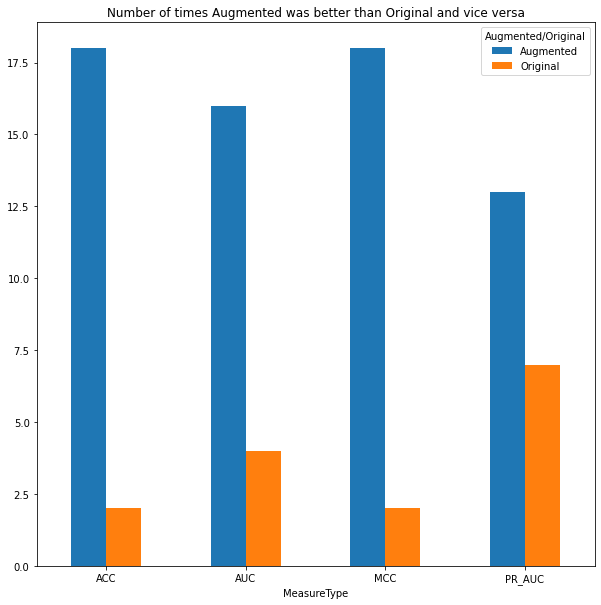

In [4]:
df = pd.read_csv('data.csv')
# drop all empty rows
df = df.dropna()
# get all rows that have _Aug in FilteringAlgorithm
df_aug = df[df['FilteringAlgorithm'].str.contains('_Aug')]
counts = {}
# go over th rows in df_aug
for index, row in df_aug.iterrows():
    # find the same row in df but without _Aug in FilteringAlgorithm
    row_without_aug = df[   (df['DatasetName'] == row['DatasetName']) & 
                            (df['LearningAlgorithm'] == row['LearningAlgorithm']) & 
                            (df['NumFeaturesSelected(K)'] == row['NumFeaturesSelected(K)']) & 
                            (df['MeasureType'] == row['MeasureType']) & 
                            (df['FilteringAlgorithm'] == row['FilteringAlgorithm'].replace('_Aug', ''))]
    # record in counts which row has the better MeasureVal with the dataset name, LearningAlgorithm, FilteringAlgorithm, NumFeaturesSelected(K) and MeasureType as key
    counts[(row['DatasetName'], 
            row['LearningAlgorithm'], 
            row['FilteringAlgorithm'][:-4], 
            row['NumFeaturesSelected(K)'], 
            row['MeasureType'])] = 'Original' if row['MeasureVal'] > row_without_aug['MeasureVal'].values[0] else 'Augmented'
for key, value in counts.items():
    print(f'{key} - {value}')

# print how many times augmented was better and vice versa
print('---------------------------------------------------------------------------------')
print('Augmented was better', len([v for v in counts.values() if v == 'Augmented']), 'times in total')
print('Original was better', len([v for v in counts.values() if v == 'Original']), 'times in total')
# plot a histogram that shows for each measure type how many times augmented was better and vice versa
df = pd.DataFrame.from_dict(counts, orient='index', columns=['Augmented/Original'])
df = df.reset_index()
df = df.rename(columns={'index': 'key'})
df['DatasetName'] = df['key'].apply(lambda x: x[0])
df['LearningAlgorithm'] = df['key'].apply(lambda x: x[1])
df['FilteringAlgorithm'] = df['key'].apply(lambda x: x[2])
df['NumFeaturesSelected(K)'] = df['key'].apply(lambda x: x[3])
df['MeasureType'] = df['key'].apply(lambda x: x[4])
df = df.drop(columns=['key'])
df = df.groupby(['MeasureType', 'Augmented/Original']).count().reset_index()
df = df.pivot(index='MeasureType', columns='Augmented/Original', values='DatasetName')
df.plot.bar(rot=0, figsize=(10, 10), title='Number of times Augmented was better than Original and vice versa')